In [1]:
from z3 import *
import numpy as np
import random
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

# our library
from sat_metropolis import smt,mcmc,utils

In [2]:
num_vars = 3
x = [Int(f'x{i}') for i in range(num_vars)]

s = Solver()

# model constraints
s.add(x[0]>=0)
s.add(x[1]>=0)
s.add(x[2]>=0)
s.add(x[0]<=3)
s.add(x[1]<=3)
s.add(x[2]<=6)
s.add(x[0] + x[1] == x[2])

**MegaSampler cannot handle this case. It times out and produces only one sample**

In [3]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='megasampler',
                                           z3_problem=s,
                                           timeout_sampler=60*10)

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 7
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 3
Reals 0
Formula tree depth 2
--------------------------------------------
starting MeGASampler
Formula is satisfiable
Stopping: timeout
---------SOLVING STATISTICS--------
do_epoch time: 408.818
epoch time: 599.888
grow_seed time: 13.4579
initial_solving time: 0.00190249
output time: 2.10213
start_epoch time: 190.82
total time: 600
Epochs: 294881
MAX-SMT calls: 294882
SMT calls: 0
Assignments considered (with repetitions): 30077761
Models (with repetitions): 30077761
Unique models (# samples in file): 1
-----------------------------------
The parameter `solver_samples` only contains 1 samples. Thus, every chain will contain 1 instead of 1. Try running the SAT/SMT sampler longer to obtain more samples.



/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/traceplot.py:426: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/traceplot.py:426: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/traceplot.py:426: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())


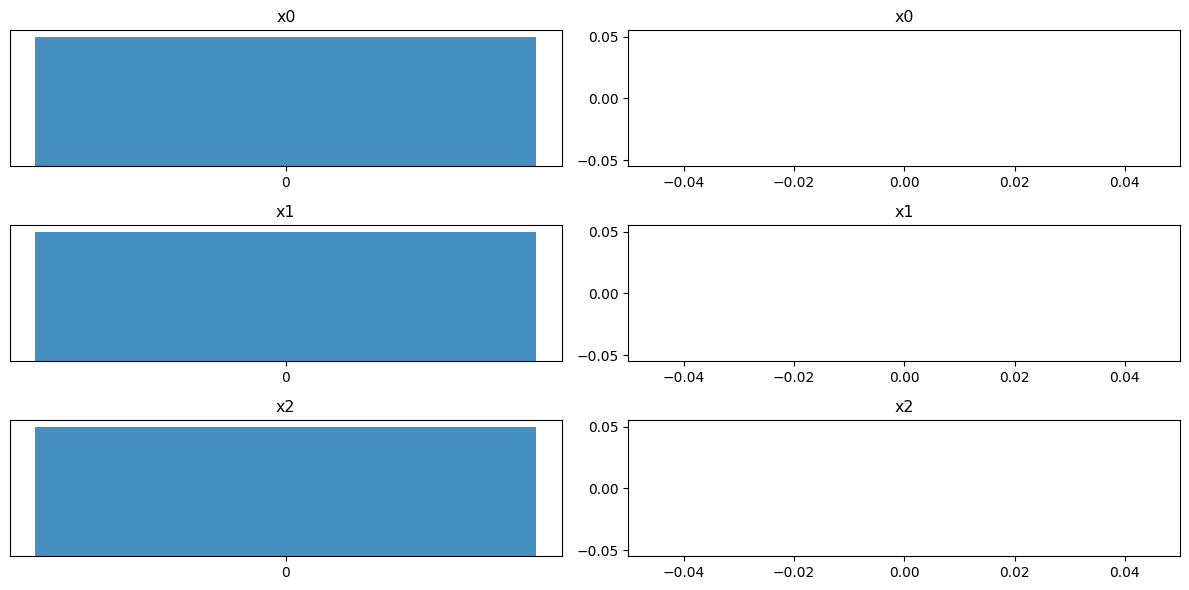

In [4]:
az.plot_trace(trace);
plt.savefig('megasampler_trace_plot.png', dpi=150);

In [5]:
# Diagnostics
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (4, 1), minimum_shape: (chains=1, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
x1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
x2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
utils.save_trace(trace, f'triangle_SMT_{num_vars}.nc')